# Data Analysis

This notebook provides data analysis code for the ReportMetricExpertEvalAlignment-v0 dataset.

## Setup

In [1]:
import os

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data_dir = ''
study_reports_path = os.path.join(data_dir, '50_samples_gt_and_candidates.csv')
errors_path = os.path.join(data_dir, '6_valid_raters_per_rater_error_categories.csv')

In [3]:
study_reports_df = pd.read_csv(study_reports_path)
errors_df = pd.read_csv(errors_path)

## Compute mean errors per study

### Compute mean number of errors over radiologists

In [4]:
def compute_mean_errors(errors_df, is_significant):
    '''Computes mean number of errors over radiologists.

    errors_df: DataFrame containing radiologist annotations.
    is_significant: Whether to look at clinically significant or insignificant
        errors.
    '''
    errors_df = errors_df.loc[
        errors_df['clinically_significant'] == is_significant]
    # Compute per-rater mean errors
    mean_errors = errors_df.groupby(
        ['study_number', 'candidate_type', 'error_category']).mean()
    mean_errors = mean_errors.drop(
        columns=['rater_index', 'clinically_significant'])
    mean_errors = mean_errors.reset_index()
    # Sum over error categories
    mean_errors = mean_errors.groupby(['study_number', 'candidate_type']).sum()
    mean_errors = mean_errors.drop(columns=['error_category'])
    mean_errors = mean_errors.reset_index()
    return mean_errors

In [5]:
sig_mean_errors = compute_mean_errors(
    errors_df=errors_df,
    is_significant=True)
display(sig_mean_errors)

insig_mean_errors = compute_mean_errors(
    errors_df=errors_df,
    is_significant=False)
display(insig_mean_errors)

,study_number,candidate_type,num_errors
0,0,bertscore,1.666667
1,0,bleu,1.666667
2,0,radgraph,0.833333
3,0,s_emb,1.833333
4,1,bertscore,1.166667
...,...,...,...
195,48,s_emb,1.166667
196,49,bertscore,0.000000
197,49,bleu,0.000000
198,49,radgraph,0.000000


,study_number,candidate_type,num_errors
0,0,bertscore,1.500000
1,0,bleu,1.000000
2,0,radgraph,1.500000
3,0,s_emb,1.666667
4,1,bertscore,0.833333
...,...,...,...
195,48,s_emb,0.166667
196,49,bertscore,0.500000
197,49,bleu,0.500000
198,49,radgraph,0.000000


### Combine clinically significant and insignificant errors

In [6]:
total_mean_errors = pd.merge(
    sig_mean_errors.rename(columns={'num_errors': 'num_sig_errors'}),
    insig_mean_errors.rename(columns={'num_errors': 'num_insig_errors'}),
    on=['study_number', 'candidate_type'])
total_mean_errors['total_num_errors'] = total_mean_errors['num_sig_errors'] + total_mean_errors['num_insig_errors']
display(total_mean_errors)

,study_number,candidate_type,num_sig_errors,num_insig_errors,total_num_errors
0,0,bertscore,1.666667,1.500000,3.166667
1,0,bleu,1.666667,1.000000,2.666667
2,0,radgraph,0.833333,1.500000,2.333333
3,0,s_emb,1.833333,1.666667,3.500000
4,1,bertscore,1.166667,0.833333,2.000000
...,...,...,...,...,...
195,48,s_emb,1.166667,0.166667,1.333333
196,49,bertscore,0.000000,0.500000,0.500000
197,49,bleu,0.000000,0.500000,0.500000
198,49,radgraph,0.000000,0.000000,0.000000


## Visualize error distributions for report pairs

In [7]:
def plot_errors(mean_errors, var):
    '''Visualizes error distributions.

    mean_errors: DataFrame containing mean errors for different studies and
        candidate types.
    var: Vertical axis variable for the bar plot.
    '''
    plt.figure()
    plt.style.use('seaborn-ticks')
    g = sns.catplot(
        data=mean_errors,
        x='study_number',
        y=var,
        hue='candidate_type',
        kind='bar',
        height=4,
        aspect=3)
    plt.title(f'Error distributions')
    plt.xlabel('Study number')
    plt.ylabel('Mean radiologist errors')
    plt.show()

<Figure size 432x288 with 0 Axes>

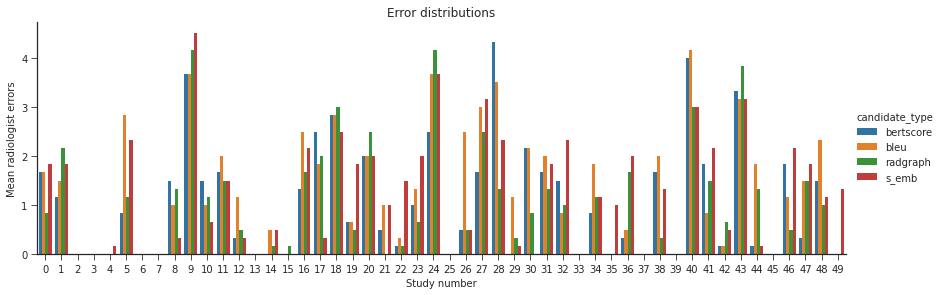

<Figure size 432x288 with 0 Axes>

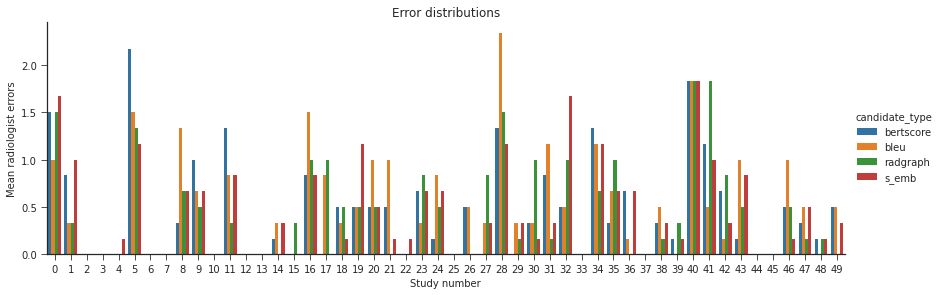

<Figure size 432x288 with 0 Axes>

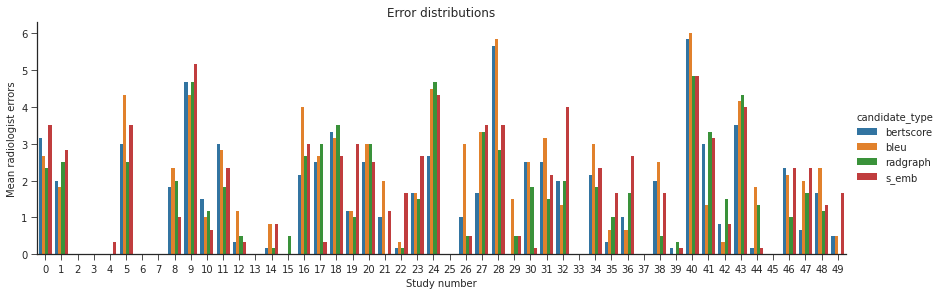

In [8]:
plot_errors(
    mean_errors=total_mean_errors,
    var='num_sig_errors')
plot_errors(
    mean_errors=total_mean_errors,
    var='num_insig_errors')
plot_errors(
    mean_errors=total_mean_errors,
    var='total_num_errors')

## Check reports

In [9]:
CANDIDATE_TYPES = [
    'bleu',
    'bertscore',
    's_emb',
    'radgraph',
]


def get_reports(study_reports_df, study_number):
    '''Fetches reports by study number.

    study_reports_df: DataFrame containing study ID, ground-truth report and
        candidate reports.
    study_number: Study number (row index).
    '''
    study = study_reports_df.iloc[study_number]
    print(f'Study ID {study["study_id"]}\n\n'
          f'* Ground-truth report: {study["gt_report"]}\n')
    for candidate_type in CANDIDATE_TYPES:
        print(f'* Candidate report ({candidate_type}): {study[candidate_type]}\n')

In [10]:
get_reports(
    study_reports_df=study_reports_df,
    study_number=9)

Study ID 54729238

* Ground-truth report: 1.  Large right hilar lung mass and radiation fibrosis.  Additional post-obstructive pneumonia in the right upper and lower lobes is possible but hard to delineate. 2.  New left retrocardiac opacity, small left effusion, and pleural thickening.  Findings were discussed with ___, RN, via telephone at ___ and again with Dr ___ at ___.

* Candidate report (bleu): 1.  Left lower lobe pneumonia with small left parapneumonic effusion. 2.  New focal airspace opacities in the right lung apex and right lung base may represent superimposition of normal structures.  Attention is recommended on followup.  Findings were discussed by Dr. ___ with Dr. ___ ___ medicine via telephone at 10:50am on ___.

* Candidate report (bertscore): 1.  Left lower lobe pneumonia with small left parapneumonic effusion. 2.  New focal airspace opacities in the right lung apex and right lung base may represent superimposition of normal structures.  Attention is recommended on fol